In [1]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import h5py
import pickle
import pandas
import matplotlib.pyplot as plt
#import deepdish.io as io
#import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from keras.models import Model,Sequential
#from keras.layers import Input, Dense, Dropout, Layer
#from keras.utils import plot_model
#from keras.models import load_model
from sklearn.preprocessing import scale, normalize
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
import random
from pca_plotter import PCAPlotter
from sklearn.metrics import roc_auc_score, roc_curve
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# Loading one of Taoli's Model
#vae = tf.keras.models.load_model('/home/zp/gupta/jetAnomaly/utils/VAE-FCN-model-d80-UdeMdata-cycannealing-eps1.h5', compile=False)

In [3]:
#vae.summary()

In [6]:
#encoder = vae.get_layer('encoder')

In [4]:
#encoder.summary()

**encoder_model**

In [2]:
def sampling(args):
    mu, sigma = args
    batch     = tf.shape(mu)[0]
    dim       = tf.shape(mu)[1]
    eps       = tf.keras.backend.random_normal(shape=(batch, dim))
    return mu + tf.exp(sigma / 2) * eps

In [13]:
input_dim = 80

input_vec = keras.Input(shape =(input_dim,))
encoding_dim = 10
x = layers.Dense(256, activation="relu")(input_vec)
#x = layers.Dense(256, activation="relu",input_shape=(80,))
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(encoding_dim, name="z_mean")(x)
z_log_var = layers.Dense(encoding_dim, name="z_log_var")(x)

In [14]:
z = layers.Lambda(sampling, output_shape=(encoding_dim,), name='z')([z_mean, z_log_var])

In [15]:
# instantiate encoder model
encoder = keras.Model(input_vec, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 80)]         0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 256)          20736       input_10[0][0]                   
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 128)          32896       dense_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 64)           8256        dense_8[0][0]                    
____________________________________________________________________________________________

In [ ]:
class Tripletnet(nn.Module):
    def __init__(self, embeddingnet):
        super(Tripletnet, self).__init__()
        self.embeddingnet = embeddingnet

    def forward(self, x, y, z):
        latent_x,mean_x,logvar_x = self.embeddingnet(x)
        latent_y,mean_y,logvar_y = self.embeddingnet(y)
        latent_z,mean_z,logvar_z = self.embeddingnet(z)
        dist_a = F.pairwise_distance(mean_x, mean_y, 2)
        dist_b = F.pairwise_distance(mean_x, mean_z, 2)
        return latent_x,mean_x,logvar_x,\
            latent_y,mean_y,logvar_y,\
            latent_z,mean_z,logvar_z,\
            dist_a, dist_b

**decoder_model**

In [6]:
latent_inputs = keras.Input(shape=(encoding_dim,), name='z_sampling')
x = layers.Dense(64, activation="relu")(latent_inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
decoder_outputs = layers.Dense(80, activation="sigmoid")(x)
#decoder_1 = keras.Model(latent_inputs, decoder_outputs, name="decoder")
#decoder_1.summary()
# instantiate decoder model
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 10)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 80)                20560     
Total params: 62,608
Trainable params: 62,608
Non-trainable params: 0
_________________________________________________________________


In [6]:
# instantiate VAE model
outputs = decoder(encoder(input_vec)[2])
vae = keras.Model(input_vec, outputs, name='vae_mlp')
vae.summary()

NameError: name 'decoder' is not defined

In [17]:
input_anchor = tf.keras.layers.Input(shape=(80,))
input_positive = tf.keras.layers.Input(shape=(80,))
input_negative = tf.keras.layers.Input(shape=(80,))

embedding_anchor = encoder(input_anchor)
embedding_positive = encoder(input_positive)
embedding_negative = encoder(input_negative)
output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)
#output = [embedding_anchor, embedding_positive, embedding_negative]
encoder_1 = tf.keras.models.Model([input_anchor, input_positive, input_negative], [embedding_anchor, embedding_positive,embedding_negative])

encoder_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 80)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 10), (None,  63188       input_11[0][0]                   
                                                                 input_12[0][0]             

In [19]:
dot_img_file = './model_1.png'
tf.keras.utils.plot_model(encoder_1, to_file=dot_img_file, show_shapes=True)

TypeError: 'Model' object does not support indexing

In [15]:
input_1 = np.array(range(0,80))
input_2 = np.array(range(80,160))
input_3 = np.array(range(160,240))

(80,)

In [16]:
def kl_reconstruction_loss(inputs, outputs):
  # Reconstruction loss
  anchor, positive, negative = concatenate[0:10], concatenate[10:20], concatenate[20:]
  reconstruction_loss = binary_crossentropy(inputs, outputs) *original_dim
  # KL divergence loss
  kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  # Total loss = 50% rec + 50% KL divergence loss
  return K.mean(reconstruction_loss + kl_loss)

In [14]:
model_new.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          20736       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
____________________________________________________________________________________________

In [16]:
anchor_outputs = decoder(embedding_anchor[2])
positive_outputs = decoder(embedding_positive[2])
negative_outputs = decoder(embedding_negative[2])
output_1 = [anchor_outputs, positive_outputs, negative_outputs]
decoder_1 = tf.keras.models.Model([input_anchor, input_positive, input_negative], output_1)
decoder_1.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 80)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 10), (None,  63188       input_11[0][0]                   
                                                                 input_12[0][0]             

In [12]:
# Define loss
def kl_reconstruction_loss(inputs, outputs):
  # Reconstruction loss
    reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)*encoding_dim
  # KL divergence loss
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
  # Total loss = 50% rec + 50% KL divergence loss
    return keras.backend.mean(reconstruction_loss + kl_loss)

In [66]:
#decoder.summary()

In [21]:
# Loading QCD sample to use jet_pT for pT scaling
fqcd=h5py.File('/home/zp/gupta/jetAnomaly/utils/qcd_pt_scaled.h5','r')
x_train = fqcd['table']

In [22]:
x_train = x_train[0:1000,:80]

In [24]:
x_train.shape
x_train = np.float32(x_train)

In [30]:
#x_train = tf.cast(x_train,tf.float32)
x_train = np.reshape(x_train, (-1, 80))

In [17]:
x_train.shape

(1000, 80)

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train))

In [45]:
x_train = np.array(x_train)
x_train = np.float32(x_train)

In [27]:
x_train[0]

array([ 1.97361171e-01,  1.97322130e-01,  1.63580687e-03, -3.56817874e-03,
        1.59170419e-01,  1.59141317e-01,  1.40896032e-03, -2.69780378e-03,
        1.57943964e-01,  1.57936066e-01, -4.66064230e-04, -1.50943385e-03,
        1.22946635e-01,  1.22095898e-01, -4.45831986e-03,  1.37327649e-02,
        9.46144238e-02,  9.45912153e-02, -4.75158122e-05, -2.09516380e-03,
        6.49932548e-02,  6.49725646e-02, -6.12275981e-05, -1.63851620e-03,
        6.27544373e-02,  6.27280623e-02,  2.08533471e-04, -1.80729665e-03,
        4.99733984e-02,  4.99622822e-02,  2.98903062e-04, -1.01071841e-03,
        3.54683101e-02,  3.54584083e-02,  2.65915674e-04, -7.94700871e-04,
        2.86832340e-02,  2.86705457e-02,  7.13755027e-04, -4.67100879e-04,
        1.32674929e-02,  1.32488161e-02,  6.59572484e-04, -2.45380856e-04,
        1.00047244e-02,  9.94572509e-03,  6.89053035e-04,  8.38012958e-04,
        2.61155656e-03,  1.69205619e-03, -1.17275247e-03,  1.60680606e-03,
        1.04583288e-03,  

In [25]:
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

In [27]:
epochs = 5
batch_size = 128
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)
        #validation_data=(valid_x_train_bkg, valid_x_train_bkg))

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1000/1000 [==============================] - 4s 4ms/sample - loss: 6.3330
Epoch 2/5
1000/1000 [==============================] - 0s 155us/sample - loss: 4.0662
Epoch 3/5
1000/1000 [==============================] - 0s 120us/sample - loss: 1.5487
Epoch 4/5
1000/1000 [==============================] - 0s 132us/sample - loss: 1.0301
Epoch 5/5
1000/1000 [==============================] - 0s 118us/sample - loss: 0.9574


In [33]:
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

In [2]:
tf.__version__

'2.1.0'

In [34]:
epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, x_train_step in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            x_train_step = np.reshape(x_train_step,(-1, 80))
            logits = vae(x_train_step, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = kl_reconstruction_loss(x_train_step, x_train_step)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, vae.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * 64))


Start of epoch 0


ValueError: No gradients provided for any variable: ['dense/kernel:0', 'dense/bias:0', 'dense_1/kernel:0', 'dense_1/bias:0', 'dense_2/kernel:0', 'dense_2/bias:0', 'z_mean/kernel:0', 'z_mean/bias:0', 'z_log_var/kernel:0', 'z_log_var/bias:0', 'dense_3/kernel:0', 'dense_3/bias:0', 'dense_4/kernel:0', 'dense_4/bias:0', 'dense_5/kernel:0', 'dense_5/bias:0', 'dense_6/kernel:0', 'dense_6/bias:0'].

In [91]:
vae.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [14]:
x_train = np.expand_dims(x_train, -1).astype("float32")

In [15]:
vae.fit(x_train, epochs=5, batch_size=100)

NotImplementedError: When subclassing the `Model` class, you should implement a `call` method.

In [10]:
# Loading QCD sample to use jet_pT for pT scaling
fqcd=h5py.File('/home/zp/gupta/jetAnomaly/utils/qcd_pt_scaled.h5','r')

In [11]:
list(fqcd.keys())

['table']

In [12]:
qcd_train_bkg = fqcd['table']

In [13]:
qcd_train_bkg.shape

(705643, 868)

In [14]:
# Taking only 80 features to match with the model
qcd_train_bkg=qcd_train_bkg[:,:80]


In [15]:
qcd_train_bkg.shape

(705643, 80)

In [16]:
qcd_train = qcd_train_bkg[0:200000]

In [17]:
qcd_train.shape

(200000, 80)

In [18]:
# Loading zboson sample to use jet_pT for pT scaling
fzboson=h5py.File('/lcg/storage13/atlas/gupta/stealth_boson/Inter_Zp2200_S80A15_pt_scaled.h5','r')
zboson_pt_scaled = fzboson['table']
zboson_pt_scaled.shape

(97579, 768)

In [19]:
# Loading ttbar sample to use jet_pT for pT scaling
fttbar=h5py.File('/home/zp/gupta/jetAnomaly/utils/ttbar_pt_scaled.h5','r')
ttbar_pt_scaled = fttbar['table']
ttbar_pt_scaled.shape

(320124, 888)

In [20]:
zboson_pt_scaled = zboson_pt_scaled[:,:80]
zboson_pt_scaled.shape

(97579, 80)

In [21]:
ttbar_pt_scaled = ttbar_pt_scaled[:,:80]
ttbar_pt_scaled.shape

(320124, 80)

In [22]:
qcd_zboson_mixed = np.concatenate((qcd_train, zboson_pt_scaled), axis=0)
y_qcd_zboson = np.concatenate((np.zeros(len(qcd_train)), np.ones(len(zboson_pt_scaled))), axis=0)

In [21]:
qcd_zboson_mixed.shape

(297579, 80)

In [22]:
y_qcd_zboson.shape

(297579,)

In [23]:
rng = check_random_state(1)
indices = rng.permutation(len(qcd_zboson_mixed))

In [24]:
x_train = [qcd_zboson_mixed[j] for j in indices[:297000]]
y_train = [y_qcd_zboson[j] for j in indices[:297000]]

In [25]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [26]:
x_train.shape

(297000, 80)

In [27]:
# separating train and test set
#x_train, x_test, y_train, y_test = train_test_split(x_mix,y_mix,
 #                                   test_size=0.3, 
 #                                   random_state=13)
qcd_test_bkg = qcd_train_bkg[200000:300000]
ttbar_test = ttbar_pt_scaled[0:50000]

In [28]:
qcd_test_bkg.shape

(100000, 80)

In [29]:
qcd_ttbar_mixed = np.concatenate((qcd_test_bkg, ttbar_test), axis=0)
y_qcd_ttbar = np.concatenate((np.zeros(len(qcd_test_bkg)), np.ones(len(ttbar_test))), axis=0)

In [30]:
qcd_ttbar_mixed.shape

(150000, 80)

In [31]:
rng = check_random_state(1)
indices_1 = rng.permutation(len(qcd_ttbar_mixed))

In [32]:
qcd_ttbar_mixed[0,0:4]

array([ 0.13922491,  0.13893765, -0.00765688, -0.00461269])

In [33]:
x_test = qcd_ttbar_mixed[indices_1]
y_test = y_qcd_ttbar[indices_1]

In [34]:
scaler = RobustScaler().fit(x_train)

In [35]:
x_test_scaled=scaler.transform(x_test)

In [36]:
x_test[0,0:4]

array([ 0.16370126,  0.163661  ,  0.00325719, -0.00160303])

In [37]:
x_test_scaled[0,0:4]

array([-0.33516201, -0.01532849,  0.13570281, -0.07856723])

In [38]:
x_train_scaled=scaler.transform(x_train)

In [39]:
x_train[0,0:4]

array([ 0.15089791,  0.15075359, -0.0060148 ,  0.00271233])

In [40]:
x_train_scaled[0,0:4]

array([-0.40942154, -0.0828771 , -0.25237278,  0.10682743])

In [41]:
bkg_index = np.where(y_train == 0)[0]

In [42]:
bkg_index

array([     0,      3,      4, ..., 296997, 296998, 296999])

In [43]:
random.choice(bkg_index)

250131

In [44]:
y_train[0]

0.0

In [45]:
def create_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, 80))
    x_positives = np.zeros((batch_size, 80))
    x_negatives = np.zeros((batch_size, 80))
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.choice(bkg_index)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

In [40]:
emb_size = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(80,)),
    tf.keras.layers.Dense(emb_size, activation='sigmoid')
])

embedding_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                5184      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 9,344
Trainable params: 9,344
Non-trainable params: 0
_________________________________________________________________


In [48]:
input_anchor = tf.keras.layers.Input(shape=(80,))
input_positive = tf.keras.layers.Input(shape=(80,))
input_negative = tf.keras.layers.Input(shape=(80,))

embedding_anchor = encoder(input_anchor)
embedding_positive = encoder(input_positive)
embedding_negative = encoder(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor[-3], embedding_positive[-3], embedding_negative[-3]], axis=1)
net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 10), (None,  63188       input_7[0][0]                    
                                                                 input_8[0][0]                    
          

In [49]:
embedding_anchor[-3].shape

TensorShape([Dimension(None), Dimension(10)])

In [50]:
alpha = 0.2
emb_size = 10
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [51]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

In [52]:
batch_size = 4096
epochs = 5
steps_per_epoch = int(x_train_scaled.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adam')

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=True,
    #callbacks=[
     #   PCAPlotter(
      #      plt, encoder,
      #      x_test_scaled[:1000], y_test[:1000]
       # )]
)

Instructions for updating:
Use tf.cast instead.


ValueError: An operation has `None` for gradient. Please make sure that all of your ops have a gradient defined (i.e. are differentiable). Common ops without gradient: K.argmax, K.round, K.eval.

In [45]:
def compute_dist(a,b):
    return np.sum(np.square(a-b))

In [46]:
def compute_probs(embedding_model,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = embedding_model.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

In [47]:
probs,yprob = compute_probs(embedding_model,x_test_scaled[:1000], y_test[:1000])

In [48]:
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)

In [49]:
auc

0.6494580734799695

In [53]:
yprob.shape

(499500,)

In [54]:
x_test_scaled[:1000].shape

(1000, 80)

In [11]:
ftest = h5py.File('/home/zp/gupta/jetAnomaly/utils/test_scaled.h5','r')

In [12]:
x_test_mix = ftest['table']

In [13]:
x_test_mix.shape

(350000, 80)

In [14]:
ftest_truth = h5py.File('/home/zp/gupta/jetAnomaly/utils/test_truth.h5','r')

In [15]:
test_truth = ftest_truth['table']

In [16]:
test_truth.shape

(350000,)

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [18]:
def num_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [26]:
data_subset = x_test_mix[0:10000, :]
truth_subset = test_truth[0:10000]

In [27]:
truth_subset.shape

(10000,)

In [28]:
import time
time_start = time.time()
RS = 123
fashion_tsne = TSNE(random_state=RS).fit_transform(data_subset)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 130.49393725395203 seconds


In [29]:
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
import matplotlib.patheffects as PathEffects

(<Figure size 576x576 with 1 Axes>,
 [Text(-6.333407, 3.150974, '0'), Text(3.2411928, -2.3621707, '1')])

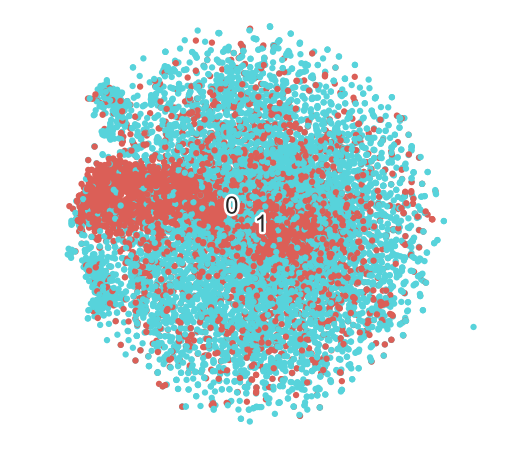

In [30]:
num_scatter(fashion_tsne, truth_subset)

In [56]:
encoded_x_train = np.array(encoded_x_train)
encoded_valid_x_train = np.array(encoded_valid_x_train)
encoded_x_test = np.array(encoded_x_test)

In [57]:
encoded_x_train = encoded_x_train[-1]
encoded_valid_x_train = encoded_valid_x_train[-1]
encoded_x_test = encoded_x_test[-1]

In [58]:
## Binary Classifier
seqModel = Sequential()
seqModel.add(Dense(64, input_dim=10, activation= 'relu'))
seqModel.add(Dense(32, activation= 'relu'))
seqModel.add(Dense(16, activation= 'relu'))
seqModel.add(Dense(8, activation= 'relu'))
seqModel.add(Dense(1, activation= 'sigmoid'))
seqModel.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])


In [59]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=8)

history=seqModel.fit(encoded_x_train, y_train_mix, epochs=100,
               batch_size=100,
               shuffle='batch',
               validation_data=(encoded_valid_x_train, valid_y_train_mix),
               callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Train on 502500 samples, validate on 215300 samples
Epoch 1/100
502500/502500 [==============================] - 34s 68us/step - loss: 0.5686 - acc: 0.7092 - val_loss: 0.5659 - val_acc: 0.7139
Epoch 2/100
502500/502500 [==============================] - 33s 66us/step - loss: 0.5649 - acc: 0.7124 - val_loss: 0.5636 - val_acc: 0.7149
Epoch 3/100
502500/502500 [==============================] - 33s 66us/step - loss: 0.5636 - acc: 0.7135 - val_loss: 0.5633 - val_acc: 0.7152
Epoch 4/100
502500/502500 [==============================] - 33s 66us/step - loss: 0.5630 - acc: 0.7148 - val_loss: 0.5637 - val_acc: 0.7147
Epoch 5/100
502500/502500 [==============================] - 33s 66us/step - loss: 0.5626 - acc: 0.7153 - val_loss: 0.5623 - val_acc: 0.7157
Epoch 6/100
502500/502500 [==============================] - 33s 66us/step - loss: 0.5622 - acc: 0.7158 - val_loss: 0.5619 - val_acc: 0.7169
Epoch 7/100
502500/502500 [===========================

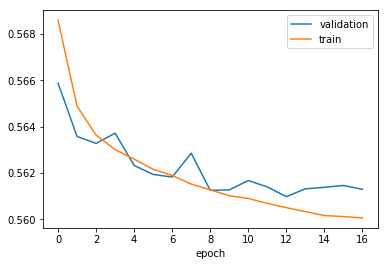

In [60]:
plt.plot(history.history['val_loss'], label='validation')
plt.plot(history.history['loss'], label='train')
#plt.title('AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [61]:
binary_truth = seqModel.predict(encoded_x_test, batch_size=100)

In [62]:
binary_truth

array([[0.21761364],
       [0.20281285],
       [0.13779566],
       ...,
       [0.05056733],
       [0.56354386],
       [0.44346488]], dtype=float32)

In [63]:
binary_truth = np.where(binary_truth<0.5, 0, binary_truth)

In [64]:
binary_truth = np.where(binary_truth!=0, 1, binary_truth)

In [65]:
binary_truth

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [66]:
predict_jets = vae.predict(x_test_mix,batch_size=100)

In [67]:
MSE_loss = np.mean(np.power(x_test_mix - predict_jets, 2), axis=1)

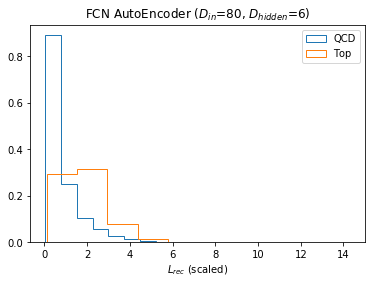

In [68]:
l_rec_0=[]
l_rec_1=[]

for i in range(10000):
    if y_test_mix[i]==0:
        l_rec_0.append(MSE_loss[i])
    else:
        l_rec_1.append(MSE_loss[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='QCD', density='true')
plt.hist(l_rec_1, histtype='step', label='Top', density='true')
plt.legend(loc='best')
plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.xlabel('$L_{rec}$ (scaled)')
plt.show()

/lcg/storage15/software64/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
No handles with labels found to put in legend.


roc_auc = 0.8397709350267817


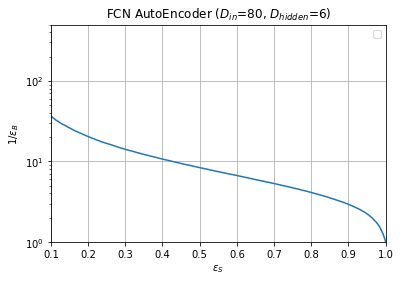

In [69]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(y_test_mix, MSE_loss)
print("roc_auc =", roc_auc_score(y_test_mix, MSE_loss))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()

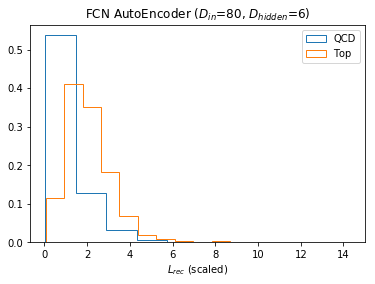

In [70]:
l_rec_0=[]
l_rec_1=[]

for i in range(10000):
    if binary_truth[i]==0:
        l_rec_0.append(MSE_loss[i])
    else:
        l_rec_1.append(MSE_loss[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='QCD', density='true')
plt.hist(l_rec_1, histtype='step', label='Top', density='true')
plt.legend(loc='best')
plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.xlabel('$L_{rec}$ (scaled)')
plt.show()

/lcg/storage15/software64/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
No handles with labels found to put in legend.


roc_auc = 0.8117609154662974


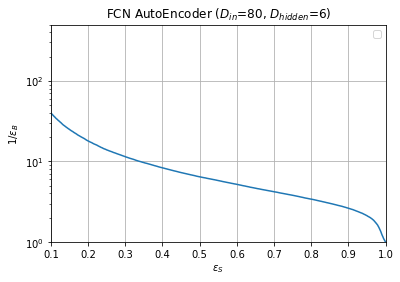

In [71]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(binary_truth, MSE_loss)
print("roc_auc =", roc_auc_score(binary_truth, MSE_loss))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()

In [73]:
seqModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________


In [74]:
seqModel.save('/home/zp/gupta/jetAnomaly/utils/VAE-FCN-model-d80-UdeMdata-cycannealing-eps1_encodeToBinary.h5')

In [37]:
x_train_bkg = fqcd['table']
ttbar_pt_scaled = fttbar['table']

In [39]:
ttbar_pt_scaled.shape

(320124, 888)

In [69]:
x_test_mix.shape

(100000, 80)

In [70]:
# Dataset at the encoded layer
encoded_test = encoded.predict(x_test_mix, batch_size=100)
#encoded_train_bkg = encoded.predict(x_train_bkg, batch_size=100)

In [71]:
encoded_test = np.array(encoded_test)

In [72]:
encoded_test[-1].shape

(100000, 10)

In [73]:
encoded_test = encoded_test[-1]

In [74]:
x_train_bkg=scaler.transform(x_train_bkg)

In [75]:
x_train_bkg = x_train_bkg[:400000]

In [76]:
x_train_bkg.shape

(400000, 80)

In [77]:
encoded_train_bkg = encoded.predict(x_train_bkg, batch_size=100)

In [78]:
encoded_train_bkg = np.array(encoded_train_bkg)

In [79]:
encoded_train_bkg = encoded_train_bkg[-1]

In [80]:
encoded_train_bkg.shape

(400000, 10)

In [119]:
hash_size = 25
sample_size, vec_size = encoded_train_bkg.shape
projections = np.random.randn(hash_size, vec_size)

In [120]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [121]:
hashed_encoded = list()

In [122]:
for i in range(sample_size):
  bools = ''
  for j in range(hash_size):
    bool = (np.dot(encoded_train_bkg[i], projections[j].T) > 0).astype('int')
    #print(bool)
    bools += str(bool)
    #print(bools)
  hashed_encoded.append(bools)

In [123]:
len(hashed_encoded)

400000

In [124]:
def getDuplicatesWithInfo(hashed_encoded):
    ''' Get duplicate element in a list along with thier indices in list
     and frequency count'''
    dictOfElems = dict()
    index = 0
    # Iterate over each element in list and keep track of index
    for elem in hashed_encoded:
        # If element exists in dict then keep its index in lisr & increment its frequency
        if elem in dictOfElems:
            dictOfElems[elem][0] += 1
            dictOfElems[elem][1].append(index)
        else:
            # Add a new entry in dictionary 
            dictOfElems[elem] = [1, [index]]
        index += 1    
 
    dictOfElems = { key:value for key, value in dictOfElems.items() }
    return dictOfElems

In [125]:
dictOfElems = getDuplicatesWithInfo(hashed_encoded)
listHash = list()
for key, value in dictOfElems.items():
  listHash.append(key)

In [126]:
listHash = np.array(listHash)

In [127]:
tableSize= len(listHash)

In [128]:
encoded_test.shape

(100000, 10)

In [129]:
sample_size, vec_size = encoded_test.shape

In [145]:
hash_truth = list()

In [146]:
len(hash_truth)

0

In [144]:
count = 0
for i in range(sample_size):
  bools = ''
  a = 1
  for j in range(hash_size):
    bool = (np.dot(encoded_test[i], projections[j].T) > 0).astype('int')
    #print(bool)
    bools += str(bool)
  #print(bools)
  for k in range(tableSize):
    #print("bools: ",bools)
    #print("listHash: ", listHash[k])
    if bools == listHash[k]:
    #sim = jaccard_similarity(bools, listHash[k])
    #if sim>0.5:
      #print(sim)
      #print("listHash: ", listHash[k])
      #a=0
      print(a)
      #print(a)
      break
  #count = 0
  if(a==1):
    count+=1
    #print(a)
  #print(count)
  hash_truth.append(a)
print(count)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

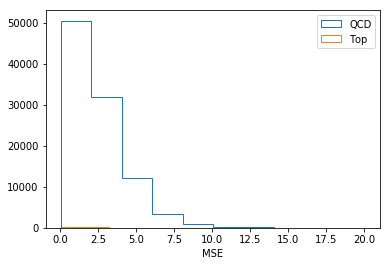

In [114]:
l_rec_0=[]
l_rec_1=[]

for i in range(100000):
    if hash_truth[i]==0:
        l_rec_0.append(MSE_loss[i])
    else:
        l_rec_1.append(MSE_loss[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='QCD',density=False)
plt.hist(l_rec_1, histtype='step', label='Top',density=False)
plt.legend(loc='best')
plt.xlabel('MSE')
#plt.yscale("log")
plt.show()

/lcg/storage15/software64/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
No handles with labels found to put in legend.


roc_auc = 0.43366577464752204


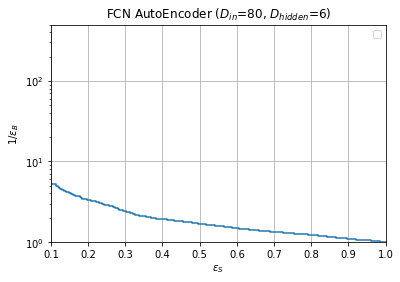

In [115]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(hash_truth, MSE_loss)
print("roc_auc =", roc_auc_score(hash_truth, MSE_loss))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()